# Sharpening for motion blur

In [1]:
#@title Libs and functions
import gc
import os
import gdown
import random
import zipfile
import cv2 as cv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from skimage.metrics import structural_similarity as compare_ssim
from tqdm import tqdm

def download_from_drive(url, name):
  gdown.download(url, name, quiet=False)
  return name

def unzip(zip_path, dest_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_path)

In [2]:
#@title Load Data
name = download_from_drive(url='https://drive.google.com/uc?id=1VWv4t5Mc1Iixt7vxvg6qg6wr7wqsIY3O', name='goproblur.zip')
unzip(zip_path=name, dest_path='./')

Downloading...
From (original): https://drive.google.com/uc?id=1VWv4t5Mc1Iixt7vxvg6qg6wr7wqsIY3O
From (redirected): https://drive.google.com/uc?id=1VWv4t5Mc1Iixt7vxvg6qg6wr7wqsIY3O&confirm=t&uuid=f2a498b4-487e-488d-8c1d-9cf3603fcc5b
To: /content/goproblur.zip
100%|██████████| 788M/788M [00:10<00:00, 75.0MB/s]


X train: (2814, 224, 224, 3) 
y train: (2814, 224, 224, 3) 
X test: (400, 224, 224, 3) 
y test: (400, 224, 224, 3)


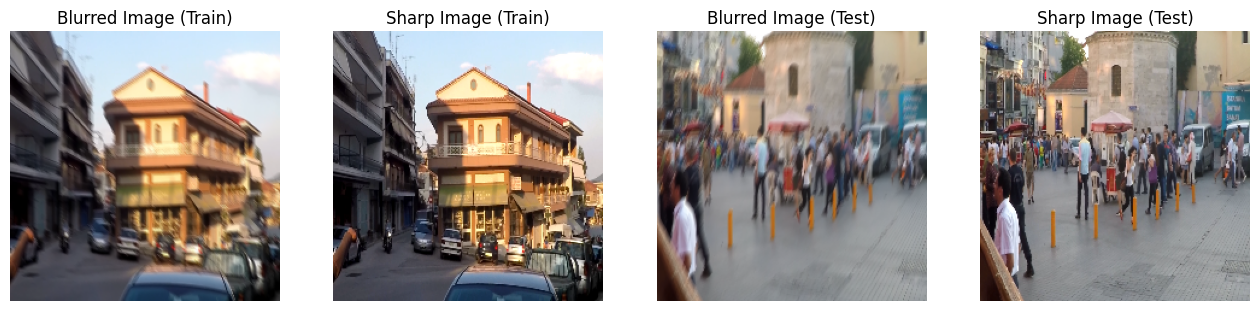

In [5]:
#@title GOPRO Dataset
X_train, y_train, X_test, y_test = np.load('/content/GOPRO_DATA/X_train.npy'), np.load('/content/GOPRO_DATA/y_train.npy'), np.load('/content/GOPRO_DATA/X_test.npy'), np.load('/content/GOPRO_DATA/y_test.npy')
print('X train:', X_train.shape,'\ny train:', y_train.shape,'\nX test:', X_test.shape,'\ny test:', y_test.shape)
plt.figure(figsize=(16, 10))
plt.subplot(141), plt.imshow(X_train[0]), plt.title('Blurred Image (Train)'), plt.axis('off')
plt.subplot(142), plt.imshow(y_train[0]), plt.title('Sharp Image (Train)'), plt.axis('off')
plt.subplot(143), plt.imshow(X_test[0]), plt.title('Blurred Image (Test)'), plt.axis('off')
plt.subplot(144), plt.imshow(y_test[0]), plt.title('Sharp Image (Test)'), plt.axis('off')
plt.show()

## Uptimus

In [6]:
#@title Utils

#Dimension del canal en pytorch
def convert_numpy_arrays(X):
  if X.max() > 1.5:
      X = X.astype(np.float32) / 255.0
  else:
      X = X.astype(np.float32)
  return np.transpose(X, (0, 3, 1, 2)).copy()

#Dataset con augmentacion
class AugmentedDataset(Dataset):
  def __init__(self, X, Y, augment=True):
    self.X = X
    self.Y = Y
    self.augment = augment

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    x = torch.from_numpy(self.X[idx]).float()
    y = torch.from_numpy(self.Y[idx]).float()

    if self.augment and np.random.rand() > 0.5:
      # Flip horizontal
      if np.random.rand() > 0.5:
        x = torch.flip(x, [2])
        y = torch.flip(y, [2])

      # Flip vertical
      if np.random.rand() > 0.5:
        x = torch.flip(x, [1])
        y = torch.flip(y, [1])

      # Rotación 90 grados
      if np.random.rand() > 0.5:
        k = np.random.randint(1, 4)
        x = torch.rot90(x, k, [1, 2])
        y = torch.rot90(y, k, [1, 2])

    return x, y


#Loss perceptual
class PerceptualLoss(nn.Module):
  def __init__(self):
    super().__init__()
    #VGG16
    vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
    #Primeras capas convolucionales
    self.features = nn.Sequential(*list(vgg.features)[:16]).eval()

    #Congelar parámetros
    for param in self.features.parameters():
        param.requires_grad = False

    #Registrar buffers para normalización
    self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
    self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

  def forward(self, pred, target):
    #Normalizar en float16
    pred = pred.float()
    target = target.float()

    pred_norm = (pred - self.mean) / self.std
    target_norm = (target - self.mean) / self.std

    pred_feat = self.features(pred_norm)
    target_feat = self.features(target_norm)

    return F.mse_loss(pred_feat, target_feat)


#L1 + Perceptual
class CombinedLoss(nn.Module):
  def __init__(self, use_perceptual=True, device='cuda'):
    super().__init__()
    self.l1_loss = nn.L1Loss()
    self.use_perceptual = use_perceptual

    if use_perceptual:
        self.perceptual = PerceptualLoss().to(device)

  def forward(self, pred, target):
    l1 = self.l1_loss(pred, target)

    if self.use_perceptual:
        perc = self.perceptual(pred, target)
        return l1 + 0.1 * perc

    return l1

#Callbacks
class EarlyStopping:
  def __init__(self, patience=7, min_delta=0.001):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_score = None
    self.should_stop = False

  def __call__(self, val_metric):
    if self.best_score is None:
        self.best_score = val_metric
    elif val_metric < self.best_score + self.min_delta:
        self.counter += 1
        if self.counter >= self.patience:
            self.should_stop = True
    else:
        self.best_score = val_metric
        self.counter = 0

class ReduceLROnPlateau:
  def __init__(self, optimizer, patience=3, factor=0.5, min_lr=1e-6):
    self.optimizer = optimizer
    self.patience = patience
    self.factor = factor
    self.min_lr = min_lr
    self.counter = 0
    self.best_score = None

  def step(self, val_metric):
    if self.best_score is None:
        self.best_score = val_metric
    elif val_metric <= self.best_score + 0.001:
        self.counter += 1
        if self.counter >= self.patience:
            self._reduce_lr()
            self.counter = 0
    else:
        self.best_score = val_metric
        self.counter = 0

  def _reduce_lr(self):
    for param_group in self.optimizer.param_groups:
      old_lr = param_group['lr']
      new_lr = max(old_lr * self.factor, self.min_lr)
      param_group['lr'] = new_lr
      print(f"\n📉 Learning rate reducido: {old_lr:.6f} → {new_lr:.6f}")

In [7]:
#@title Blocks

def window_partition(x, ws):
  B, C, H, W = x.shape
  x = x.view(B, C, H//ws, ws, W//ws, ws)
  x = x.permute(0,2,4,3,5,1).contiguous()
  return x.view(-1, ws*ws, C)

def window_reverse(windows, ws, H, W):
  total = windows.shape[0]
  B = total // ((H//ws) * (W//ws))
  x = windows.view(B, H//ws, W//ws, ws, ws, -1)
  x = x.permute(0,5,1,3,2,4).contiguous()
  return x.view(B, -1, H, W)

class WindowAttention(nn.Module):
  def __init__(self, dim, ws, heads):
    super().__init__()
    self.ws = ws
    self.heads = heads
    self.dim = dim
    self.head_dim = dim // heads
    self.scale = self.head_dim ** -0.5
    self.qkv = nn.Linear(dim, dim*3)
    self.proj = nn.Linear(dim, dim)

  def forward(self, x):
    B_, N, C = x.shape
    qkv = self.qkv(x).reshape(B_, N, 3, self.heads, self.head_dim)
    q, k, v = qkv.permute(2,0,3,1,4)
    q = q * self.scale
    attn = (q @ k.transpose(-2,-1))
    attn = F.softmax(attn, dim=-1)
    out = (attn @ v).transpose(1,2).reshape(B_, N, C)
    return self.proj(out)

class LeFF(nn.Module):
  def __init__(self, dim, hidden):
    super().__init__()
    self.fc1 = nn.Linear(dim, hidden)
    self.dw = nn.Conv2d(hidden, hidden, 3, padding=1, groups=hidden)
    self.fc2 = nn.Linear(hidden, dim)
    self.act = nn.GELU()

  def forward(self, x, H, W):
    B,N,C = x.shape
    h = self.act(self.fc1(x))
    h2 = h.permute(0,2,1).view(B,-1,H,W)
    h2 = self.dw(h2)
    h2 = h2.view(B,-1,N).permute(0,2,1)
    return self.fc2(self.act(h2))

class LeWinBlock(nn.Module):
  def __init__(self, dim, ws=8, heads=4, mlp_ratio=4):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim)
    self.attn = WindowAttention(dim, ws, heads)
    self.norm2 = nn.LayerNorm(dim)
    self.mlp = LeFF(dim, int(dim*mlp_ratio))
    self.ws = ws

  def forward(self, x, H, W):
    B,N,C = x.shape
    x1 = self.norm1(x)
    x1 = x1.view(B,H,W,C).permute(0,3,1,2)
    win = window_partition(x1, self.ws)
    win = self.attn(win)
    x2 = window_reverse(win, self.ws, H, W)
    x2 = x2.permute(0,2,3,1).view(B,N,C)
    x = x + x2
    x = x + self.mlp(self.norm2(x), H, W)
    return x

In [8]:
#@title Uptimus

class Uptimus(nn.Module):
  def __init__(self, base=24, ws=8, heads=2):
    super().__init__()
    self.ws = ws

    self.in_proj = nn.Conv2d(3, base, 3, padding=1)

    self.enc1 = LeWinBlock(base, ws, heads, mlp_ratio=2)
    self.down1 = nn.Conv2d(base, base*2, 4, stride=2, padding=1)
    self.enc2 = LeWinBlock(base*2, ws, heads, mlp_ratio=2)
    self.down2 = nn.Conv2d(base*2, base*4, 4, stride=2, padding=1)

    self.bot = LeWinBlock(base*4, ws, heads, mlp_ratio=2)

    self.up1 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
    self.reduce1 = nn.Conv2d(base*4, base*2, 1)
    self.dec1 = LeWinBlock(base*2, ws, heads, mlp_ratio=2)
    self.up2 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
    self.reduce2 = nn.Conv2d(base*2, base, 1)
    self.dec2 = LeWinBlock(base, ws, heads, mlp_ratio=2)

    self.out_proj = nn.Conv2d(base, 3, 3, padding=1)

  def run_block(self, x, block):
    B, C, H, W = x.shape
    N = H * W
    x_flat = x.permute(0, 2, 3, 1).reshape(B, N, C)
    x_out = block(x_flat, H, W)
    return x_out.view(B, H, W, C).permute(0, 3, 1, 2)

  def forward(self, x):
    f = self.in_proj(x)
    # Encoder
    e1 = self.run_block(f, self.enc1)
    d1 = self.down1(e1)
    e2 = self.run_block(d1, self.enc2)
    d2 = self.down2(e2)
    # Bottleneck
    b = self.run_block(d2, self.bot)
    # Decoder
    u1 = self.up1(b)
    u1 = torch.cat([u1, e2], dim=1)
    u1 = self.reduce1(u1)
    u1 = self.run_block(u1, self.dec1)
    u2 = self.up2(u1)
    u2 = torch.cat([u2, e1], dim=1)
    u2 = self.reduce2(u2)
    u2 = self.run_block(u2, self.dec2)

    out = self.out_proj(u2)
    return x + out

In [9]:
#@title Dataloaders
X_train_t = convert_numpy_arrays(X_train)
y_train_t = convert_numpy_arrays(y_train)
X_test_t = convert_numpy_arrays(X_test)
y_test_t = convert_numpy_arrays(y_test)

train_dataset = AugmentedDataset(X_train_t, y_train_t, augment=True)
test_dataset = AugmentedDataset(X_test_t, y_test_t, augment=False)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
#@title Train

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = Uptimus(base=24, ws=8, heads=2).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros: {params:,}\n")
#Loss
loss_fn = CombinedLoss(use_perceptual=True, device=device)
INITIAL_LR = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=0.01, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

#Callbacks
early_stop = EarlyStopping(patience=10, min_delta=0.01)
lr_reducer = ReduceLROnPlateau(optimizer, patience=4, factor=0.5)

scaler = torch.cuda.amp.GradScaler()

#Train
EPOCHS = 80
best_psnr = 0
history = {'train_loss': [], 'psnr': [], 'ssim': []}

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb in train_bar:
      xb = xb.to(device, non_blocking=True)
      yb = yb.to(device, non_blocking=True)

      with torch.cuda.amp.autocast():
          pred = model(xb)

      loss = loss_fn(pred, yb)

      optimizer.zero_grad(set_to_none=True)
      scaler.scale(loss).backward()

      scaler.unscale_(optimizer)
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      scaler.step(optimizer)
      scaler.update()

      epoch_loss += loss.item()
      train_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)

    model.eval()
    psnr_list = []
    ssim_list = []

    with torch.no_grad():
      for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        pred = model(xb)
        pred = torch.clamp(pred, 0, 1)

        for i in range(pred.shape[0]):
          mse = F.mse_loss(pred[i], yb[i]).item()
          psnr_val = 10 * math.log10(1.0 / (mse + 1e-10))
          psnr_list.append(psnr_val)

          p = pred[i].cpu().numpy().transpose(1,2,0)
          t = yb[i].cpu().numpy().transpose(1,2,0)
          ssim_val = compare_ssim(t, p, channel_axis=2, data_range=1.0)
          ssim_list.append(ssim_val)

    psnr_mean = np.mean(psnr_list)
    ssim_mean = np.mean(ssim_list)
    psnr_std = np.std(psnr_list)

    history['psnr'].append(psnr_mean)
    history['ssim'].append(ssim_mean)

    current_lr = optimizer.param_groups[0]['lr']

    print(f"\n[Epoch {epoch}] Loss={avg_loss:.4f}   "
          f"PSNR={psnr_mean:.2f}±{psnr_std:.2f}   "
          f"SSIM={ssim_mean:.4f}   LR={current_lr:.6f}")

    scheduler.step()
    lr_reducer.step(psnr_mean)
    early_stop(psnr_mean)

    if psnr_mean > best_psnr:
      best_psnr = psnr_mean
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'psnr': psnr_mean,
          'ssim': ssim_mean,
      }, "Uptimus.pth")
      print("Guardado mejor modelo (Uptimus.pth)")

    if early_stop.should_stop:
      print(f"Early stopping en la epoca {epoch}")
      break

print("\n" + "="*60)
print(f"ENTRENAMIENTO COMPLETADO")
print(f"Mejor PSNR: {best_psnr:.2f}")
print("="*60)

np.save('training_history2.npy', history)

Device: cuda
Parámetros: 249,819



Using cache found in /home/zeus/.cache/torch/hub/pytorch_vision_v0.10.0
/tmp/ipykernel_2976/3070179433.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/80:   0%|          | 0/235 [00:00<?, ?it/s]/tmp/ipykernel_2976/3070179433.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.7441]



[Epoch 1] Loss=0.6323   PSNR=28.04±2.50   SSIM=0.9147   LR=0.000500
Guardado mejor modelo (Uptimus.pth)


Epoch 2/80: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s, loss=0.4062]



[Epoch 2] Loss=0.5862   PSNR=28.00±2.40   SSIM=0.9160   LR=0.000488


Epoch 3/80: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s, loss=0.4803]



[Epoch 3] Loss=0.5809   PSNR=28.11±2.47   SSIM=0.9165   LR=0.000452
Guardado mejor modelo (Uptimus.pth)


Epoch 4/80: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s, loss=0.5466]



[Epoch 4] Loss=0.5675   PSNR=27.94±2.28   SSIM=0.9161   LR=0.000397


Epoch 5/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.7277]



[Epoch 5] Loss=0.5490   PSNR=28.14±2.36   SSIM=0.9180   LR=0.000328
Guardado mejor modelo (Uptimus.pth)


Epoch 6/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4370]



[Epoch 6] Loss=0.5353   PSNR=28.20±2.36   SSIM=0.9195   LR=0.000251
Guardado mejor modelo (Uptimus.pth)


Epoch 7/80: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s, loss=0.4634]



[Epoch 7] Loss=0.5264   PSNR=28.20±2.40   SSIM=0.9183   LR=0.000173


Epoch 8/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5317]



[Epoch 8] Loss=0.5214   PSNR=28.27±2.43   SSIM=0.9193   LR=0.000104
Guardado mejor modelo (Uptimus.pth)


Epoch 9/80: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s, loss=0.5329]



[Epoch 9] Loss=0.5182   PSNR=28.27±2.43   SSIM=0.9196   LR=0.000049
Guardado mejor modelo (Uptimus.pth)


Epoch 10/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5698]



[Epoch 10] Loss=0.5168   PSNR=28.27±2.43   SSIM=0.9197   LR=0.000013
Guardado mejor modelo (Uptimus.pth)


Epoch 11/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3635]



[Epoch 11] Loss=0.5208   PSNR=28.26±2.44   SSIM=0.9199   LR=0.000500


Epoch 12/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5976]



[Epoch 12] Loss=0.5145   PSNR=28.34±2.46   SSIM=0.9211   LR=0.000497
Guardado mejor modelo (Uptimus.pth)


Epoch 13/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4074]



[Epoch 13] Loss=0.5081   PSNR=28.24±2.44   SSIM=0.9185   LR=0.000488


Epoch 14/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.8551]



[Epoch 14] Loss=0.5047   PSNR=28.39±2.53   SSIM=0.9207   LR=0.000473
Guardado mejor modelo (Uptimus.pth)


Epoch 15/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6419]



[Epoch 15] Loss=0.4996   PSNR=28.39±2.54   SSIM=0.9202   LR=0.000452


Epoch 16/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5234]



[Epoch 16] Loss=0.4952   PSNR=28.46±2.57   SSIM=0.9220   LR=0.000427
Guardado mejor modelo (Uptimus.pth)


Epoch 17/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3340]



[Epoch 17] Loss=0.4912   PSNR=28.46±2.53   SSIM=0.9223   LR=0.000397


Epoch 18/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4806]



[Epoch 18] Loss=0.4886   PSNR=28.51±2.68   SSIM=0.9212   LR=0.000364
Guardado mejor modelo (Uptimus.pth)


Epoch 19/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6099]



[Epoch 19] Loss=0.4857   PSNR=28.60±2.71   SSIM=0.9220   LR=0.000328
Guardado mejor modelo (Uptimus.pth)


Epoch 20/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4696]



[Epoch 20] Loss=0.4830   PSNR=28.63±2.73   SSIM=0.9228   LR=0.000290
Guardado mejor modelo (Uptimus.pth)


Epoch 21/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5269]



[Epoch 21] Loss=0.4801   PSNR=28.60±2.72   SSIM=0.9223   LR=0.000251


Epoch 22/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4559]



[Epoch 22] Loss=0.4774   PSNR=28.61±2.73   SSIM=0.9225   LR=0.000211


Epoch 23/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4653]



[Epoch 23] Loss=0.4762   PSNR=28.66±2.75   SSIM=0.9233   LR=0.000173
Guardado mejor modelo (Uptimus.pth)


Epoch 24/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6095]



[Epoch 24] Loss=0.4744   PSNR=28.66±2.75   SSIM=0.9228   LR=0.000137
Guardado mejor modelo (Uptimus.pth)


Epoch 25/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3900]



[Epoch 25] Loss=0.4723   PSNR=28.71±2.81   SSIM=0.9230   LR=0.000104
Guardado mejor modelo (Uptimus.pth)


Epoch 26/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6119]



[Epoch 26] Loss=0.4717   PSNR=28.74±2.81   SSIM=0.9237   LR=0.000074
Guardado mejor modelo (Uptimus.pth)


Epoch 27/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3698]



[Epoch 27] Loss=0.4702   PSNR=28.74±2.81   SSIM=0.9237   LR=0.000049


Epoch 28/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.5025]



[Epoch 28] Loss=0.4699   PSNR=28.72±2.80   SSIM=0.9235   LR=0.000028


Epoch 29/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6888]



[Epoch 29] Loss=0.4693   PSNR=28.72±2.79   SSIM=0.9237   LR=0.000013


Epoch 30/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3638]



[Epoch 30] Loss=0.4688   PSNR=28.72±2.79   SSIM=0.9235   LR=0.000004

📉 Learning rate reducido: 0.000500 → 0.000250


Epoch 31/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4646]



[Epoch 31] Loss=0.4730   PSNR=28.72±2.77   SSIM=0.9236   LR=0.000250


Epoch 32/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5149]



[Epoch 32] Loss=0.4773   PSNR=28.61±2.74   SSIM=0.9221   LR=0.000499


Epoch 33/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6011]



[Epoch 33] Loss=0.4736   PSNR=28.83±2.84   SSIM=0.9248   LR=0.000497
Guardado mejor modelo (Uptimus.pth)


Epoch 34/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3794]



[Epoch 34] Loss=0.4713   PSNR=28.79±2.79   SSIM=0.9244   LR=0.000493


Epoch 35/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5091]



[Epoch 35] Loss=0.4681   PSNR=28.73±2.77   SSIM=0.9240   LR=0.000488


Epoch 36/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4258]



[Epoch 36] Loss=0.4657   PSNR=28.78±2.85   SSIM=0.9235   LR=0.000481


Epoch 37/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4108]



[Epoch 37] Loss=0.4631   PSNR=28.85±2.87   SSIM=0.9252   LR=0.000473
Guardado mejor modelo (Uptimus.pth)


Epoch 38/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.3568]



[Epoch 38] Loss=0.4610   PSNR=28.85±2.84   SSIM=0.9252   LR=0.000463


Epoch 39/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5407]



[Epoch 39] Loss=0.4597   PSNR=28.84±2.85   SSIM=0.9242   LR=0.000452


Epoch 40/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.3794]



[Epoch 40] Loss=0.4572   PSNR=28.89±2.83   SSIM=0.9258   LR=0.000440
Guardado mejor modelo (Uptimus.pth)


Epoch 41/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4878]



[Epoch 41] Loss=0.4557   PSNR=28.85±2.90   SSIM=0.9245   LR=0.000427


Epoch 42/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3578]



[Epoch 42] Loss=0.4534   PSNR=28.86±2.89   SSIM=0.9253   LR=0.000413


Epoch 43/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.2685]



[Epoch 43] Loss=0.4524   PSNR=28.89±2.87   SSIM=0.9257   LR=0.000397


Epoch 44/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3945]



[Epoch 44] Loss=0.4505   PSNR=28.94±2.89   SSIM=0.9260   LR=0.000381
Guardado mejor modelo (Uptimus.pth)


Epoch 45/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.3747]



[Epoch 45] Loss=0.4495   PSNR=28.93±2.87   SSIM=0.9267   LR=0.000364


Epoch 46/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3191]



[Epoch 46] Loss=0.4475   PSNR=28.94±2.91   SSIM=0.9260   LR=0.000346
Guardado mejor modelo (Uptimus.pth)


Epoch 47/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4184]



[Epoch 47] Loss=0.4462   PSNR=28.96±2.92   SSIM=0.9259   LR=0.000328
Guardado mejor modelo (Uptimus.pth)


Epoch 48/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4482]



[Epoch 48] Loss=0.4442   PSNR=29.00±2.89   SSIM=0.9271   LR=0.000309
Guardado mejor modelo (Uptimus.pth)


Epoch 49/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.4858]



[Epoch 49] Loss=0.4435   PSNR=28.95±2.90   SSIM=0.9266   LR=0.000290


Epoch 50/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4390]



[Epoch 50] Loss=0.4420   PSNR=28.96±2.87   SSIM=0.9266   LR=0.000270


Epoch 51/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4690]



[Epoch 51] Loss=0.4408   PSNR=28.95±2.91   SSIM=0.9269   LR=0.000251


Epoch 52/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6506]



[Epoch 52] Loss=0.4399   PSNR=28.92±2.87   SSIM=0.9265   LR=0.000231

📉 Learning rate reducido: 0.000211 → 0.000106


Epoch 53/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4213]



[Epoch 53] Loss=0.4366   PSNR=28.96±2.90   SSIM=0.9269   LR=0.000106


Epoch 54/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3113]



[Epoch 54] Loss=0.4370   PSNR=28.99±2.90   SSIM=0.9277   LR=0.000192


Epoch 55/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.6345]



[Epoch 55] Loss=0.4367   PSNR=29.02±2.90   SSIM=0.9276   LR=0.000173
Guardado mejor modelo (Uptimus.pth)


Epoch 56/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4469]



[Epoch 56] Loss=0.4356   PSNR=29.00±2.88   SSIM=0.9278   LR=0.000155


Epoch 57/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3996]



[Epoch 57] Loss=0.4349   PSNR=28.94±2.92   SSIM=0.9268   LR=0.000137


Epoch 58/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4047]



[Epoch 58] Loss=0.4343   PSNR=28.99±2.90   SSIM=0.9276   LR=0.000120


Epoch 59/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4347]



[Epoch 59] Loss=0.4331   PSNR=29.01±2.92   SSIM=0.9274   LR=0.000104

📉 Learning rate reducido: 0.000088 → 0.000044


Epoch 60/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.2614]



[Epoch 60] Loss=0.4316   PSNR=29.00±2.91   SSIM=0.9276   LR=0.000044


Epoch 61/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3614]



[Epoch 61] Loss=0.4316   PSNR=29.03±2.93   SSIM=0.9278   LR=0.000074
Guardado mejor modelo (Uptimus.pth)


Epoch 62/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4531]



[Epoch 62] Loss=0.4317   PSNR=29.03±2.92   SSIM=0.9276   LR=0.000061
Guardado mejor modelo (Uptimus.pth)


Epoch 63/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3881]



[Epoch 63] Loss=0.4306   PSNR=29.02±2.92   SSIM=0.9277   LR=0.000049


Epoch 64/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.3548]



[Epoch 64] Loss=0.4308   PSNR=29.03±2.93   SSIM=0.9278   LR=0.000038


Epoch 65/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.3627]



[Epoch 65] Loss=0.4299   PSNR=29.00±2.91   SSIM=0.9275   LR=0.000028

📉 Learning rate reducido: 0.000020 → 0.000010


Epoch 66/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4556]



[Epoch 66] Loss=0.4297   PSNR=29.02±2.92   SSIM=0.9278   LR=0.000010


Epoch 67/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4008]



[Epoch 67] Loss=0.4294   PSNR=29.03±2.92   SSIM=0.9278   LR=0.000013


Epoch 68/80: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.4613]



[Epoch 68] Loss=0.4296   PSNR=29.01±2.92   SSIM=0.9277   LR=0.000008


Epoch 69/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.4857]



[Epoch 69] Loss=0.4294   PSNR=29.02±2.92   SSIM=0.9279   LR=0.000004

📉 Learning rate reducido: 0.000002 → 0.000001


Epoch 70/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5362]



[Epoch 70] Loss=0.4297   PSNR=29.03±2.92   SSIM=0.9279   LR=0.000001


Epoch 71/80: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.5827]



[Epoch 71] Loss=0.4426   PSNR=28.97±2.88   SSIM=0.9273   LR=0.000500
Early stopping en la epoca 71

ENTRENAMIENTO COMPLETADO
Mejor PSNR: 29.03


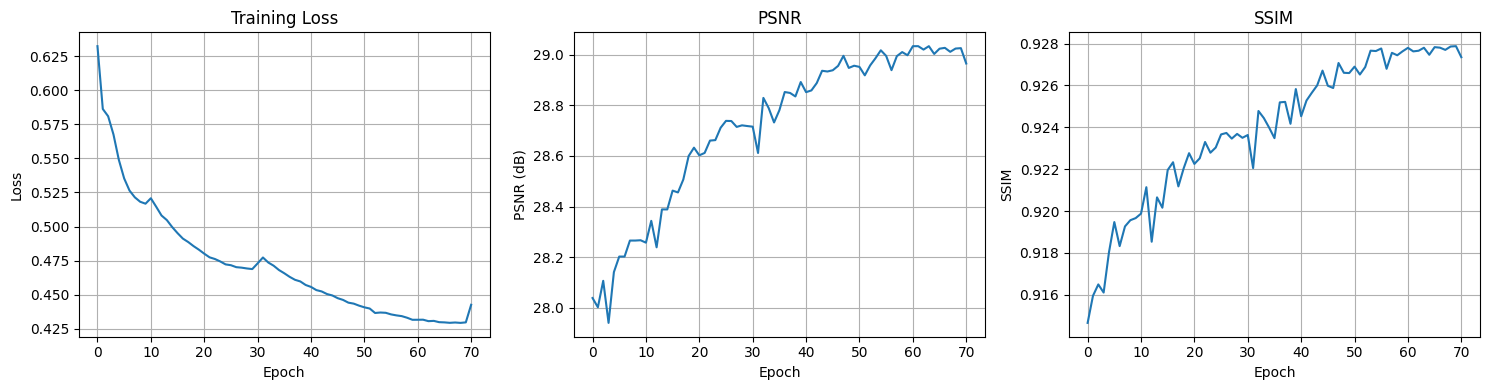

In [ ]:
#@title Hist
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(history['psnr'])
axes[1].set_title('PSNR')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('PSNR (dB)')
axes[1].grid(True)

axes[2].plot(history['ssim'])
axes[2].set_title('SSIM')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('SSIM')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_curves2.png', dpi=150)

In [13]:
#@title Metrics
print(f"PSNR: {checkpoint['psnr']:.2f} dB")
print(f"SSIM: {checkpoint['ssim']:.4f}")

PSNR: 29.04 dB
SSIM: 0.9282


In [16]:
#@title y_pred
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Uptimus(base=24, ws=8, heads=2).to(device)
checkpoint = torch.load("/content/Uptimus.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

y_pred_list = []

with torch.no_grad():
    for i in tqdm(range(len(X_test_t)), desc="Predict"):
        x_sample = torch.from_numpy(X_test_t[i:i+1]).float().to(device)

        pred_sample = model(x_sample)
        pred_sample = torch.clamp(pred_sample, 0, 1)

        pred_np = pred_sample[0].cpu().numpy()
        y_pred_list.append(pred_np)

y_pred = np.stack(y_pred_list, axis=0)
y_pred = np.transpose(y_pred, (0, 2, 3, 1))

np.save('Uptimus.npy', y_pred)
print("Preds saved as: Uptimus.npy")
print(f"Shape: {y_pred.shape}")

Predict: 100%|██████████| 400/400 [02:49<00:00,  2.37it/s]


Preds saved as: Uptimus.npy
Shape: (400, 224, 224, 3)


## Results

In [ ]:


# ==========================================
# 1. CONFIGURACIÓN FINAL (COORDENADAS CORREGIDAS)
# ==========================================


# TAMAÑO DE LA "LUPA" (Lo que captura)
ZOOM_SIZE = 30
COLORS = ['#00FFFF', '#FFD700'] # Cyan y Dorado

def plot_compact_card(fig, outer_grid_cell, img_data, idx, title=None, title_color='#333333'):

    # --- GRID INTERNO SIN ESPACIOS ---
    # Dividimos la celda: 75% imagen arriba, 25% zooms abajo
    inner_grid = GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer_grid_cell,
                        wspace=0.02, hspace=0.02, # Espacio mínimo entre zooms
                        height_ratios=[1, 0.35])  # Proporción Imagen vs Zooms

    ax_main = plt.Subplot(fig, inner_grid[0, :]) # Imagen ocupa todo el ancho arriba
    ax_z1 = plt.Subplot(fig, inner_grid[1, 0])   # Zoom 1 abajo izq
    ax_z2 = plt.Subplot(fig, inner_grid[1, 1])   # Zoom 2 abajo der

    fig.add_subplot(ax_main); fig.add_subplot(ax_z1); fig.add_subplot(ax_z2)

    # Procesar imagen
    disp_img = np.clip(img_data, 0, 1) if img_data.max() <= 1.0 else np.clip(img_data, 0, 255).astype('uint8')
    img_h, img_w = disp_img.shape[:2]

    # --- 1. IMAGEN PRINCIPAL ---
    ax_main.imshow(disp_img, aspect='auto') # 'auto' ayuda a llenar el hueco

    # Títulos pegaditos arriba (dentro del axes para ahorrar espacio)
    if title:
        ax_main.text(0.5, 1.02, title, transform=ax_main.transAxes,
                     fontsize=11, fontweight='bold', color=title_color,
                     ha='center', va='bottom')

    ax_main.set_xticks([]); ax_main.set_yticks([])
    # Quitar bordes feos
    for spine in ax_main.spines.values(): spine.set_visible(False)

    # --- 2. ZOOMS ---
    coords = custom_zooms.get(idx, [(img_w//2, img_h//2), (img_w//3, img_h//3)])
    axes_zooms = [ax_z1, ax_z2]

    for k in range(2):
        ax_curr = axes_zooms[k]
        color_curr = COLORS[k]

        if k < len(coords): x_cen, y_cen = coords[k]
        else: x_cen, y_cen = img_w//2, img_h//2

        # Calcular caja
        x1, x2 = x_cen - ZOOM_SIZE, x_cen + ZOOM_SIZE
        y1, y2 = y_cen - ZOOM_SIZE, y_cen + ZOOM_SIZE

        # Clamping
        if x1 < 0: x2 -= x1; x1 = 0
        if y1 < 0: y2 -= y1; y1 = 0
        if x2 > img_w: x1 -= (x2 - img_w); x2 = img_w
        if y2 > img_h: y1 -= (y2 - img_h); y2 = img_h

        # Dibujar recuadro (Más grueso para que se note en diapositivas)
        rect = Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor=color_curr, facecolor='none')
        ax_main.add_patch(rect)

        # Pintar el Zoom
        zoom_patch = disp_img[int(y1):int(y2), int(x1):int(x2)]
        ax_curr.imshow(zoom_patch, aspect='auto') # Auto para llenar el cuadrito
        ax_curr.set_xticks([]); ax_curr.set_yticks([])

        # Borde de color solido alrededor del zoom
        for spine in ax_curr.spines.values():
            spine.set_edgecolor(color_curr)
            spine.set_linewidth(3.0) # Borde gordo estilo paper

    return ax_main


In [ ]:
custom_zooms = {
    3:   [(160, 80), (180, 180)],
    150: [(210, 180), (130, 130)],
    200: [(125, 60), (100, 180)],   # Tu corrección de la ventana centrada
}

indices_a_ver = [3, 150, 200]



def plot(idx, zooms uptimus, naftnet, residual_unet):
  num_cols = 5
  num_rows = len(idx)

  fig = plt.figure(figsize=(20, 3.5 * num_rows), dpi=150, facecolor='white')
  outer_grid = GridSpec(num_rows, num_cols, wspace=0.05, hspace=0.1)

  for row_idx, i in enumerate(idx):
    if i >= len(X_test): continue
    sharp = y_test[i]
    blur = X_test[i]
    residual_unet = residual_unet[i]
    naftnet = naftnet[i]
    uptimus = uptimus[i]


    first_row = (row_idx == 0)

    ax = plot_models(fig, zooms, outer_grid[row_idx, 0], sharp, i, title="Ground Truth" if first_row else None)

    plot_models(fig, zooms, outer_grid[row_idx, 1], blur, i, title="Blurred Input" if first_row else None)

    plot_models(fig, zooms, outer_grid[row_idx, 2], residual_unet, i, title="Residual U-Net" if first_row else None, title_color='#003366')

    plot_models(fig, zooms, outer_grid[row_idx, 4], naftnet, i, title="NafNet" if first_row else None, title_color='#a349a4')

    plot_models(fig, zooms, outer_grid[row_idx, 3], uptimus, i, title="Uptimus" if first_row else None, title_color='#ff6347')

  plt.subplots_adjust(left=0.03, right=0.97, top=0.93, bottom=0.03)
  plt.show()

In [ ]:


# ==========================================
# 1. CONFIGURACIÓN FINAL (COORDENADAS CORREGIDAS)
# ==========================================
custom_zooms = {
    3:   [(160, 80), (180, 180)],
    150: [(210, 180), (130, 130)],
    200: [(125, 60), (100, 180)],   # Tu corrección de la ventana centrada
}

indices_a_ver = [3, 150, 200]

# TAMAÑO DE LA "LUPA" (Lo que captura)
ZOOM_SIZE = 30
COLORS = ['#00FFFF', '#FFD700'] # Cyan y Dorado

def plot_compact_card(fig, outer_grid_cell, img_data, idx, title=None, title_color='#333333'):

    # --- GRID INTERNO SIN ESPACIOS ---
    # Dividimos la celda: 75% imagen arriba, 25% zooms abajo
    inner_grid = GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer_grid_cell,
                        wspace=0.02, hspace=0.02, # Espacio mínimo entre zooms
                        height_ratios=[1, 0.35])  # Proporción Imagen vs Zooms

    ax_main = plt.Subplot(fig, inner_grid[0, :]) # Imagen ocupa todo el ancho arriba
    ax_z1 = plt.Subplot(fig, inner_grid[1, 0])   # Zoom 1 abajo izq
    ax_z2 = plt.Subplot(fig, inner_grid[1, 1])   # Zoom 2 abajo der

    fig.add_subplot(ax_main); fig.add_subplot(ax_z1); fig.add_subplot(ax_z2)

    # Procesar imagen
    disp_img = np.clip(img_data, 0, 1) if img_data.max() <= 1.0 else np.clip(img_data, 0, 255).astype('uint8')
    img_h, img_w = disp_img.shape[:2]

    # --- 1. IMAGEN PRINCIPAL ---
    ax_main.imshow(disp_img, aspect='auto') # 'auto' ayuda a llenar el hueco

    # Títulos pegaditos arriba (dentro del axes para ahorrar espacio)
    if title:
        ax_main.text(0.5, 1.02, title, transform=ax_main.transAxes,
                     fontsize=11, fontweight='bold', color=title_color,
                     ha='center', va='bottom')

    ax_main.set_xticks([]); ax_main.set_yticks([])
    # Quitar bordes feos
    for spine in ax_main.spines.values(): spine.set_visible(False)

    # --- 2. ZOOMS ---
    coords = custom_zooms.get(idx, [(img_w//2, img_h//2), (img_w//3, img_h//3)])
    axes_zooms = [ax_z1, ax_z2]

    for k in range(2):
        ax_curr = axes_zooms[k]
        color_curr = COLORS[k]

        if k < len(coords): x_cen, y_cen = coords[k]
        else: x_cen, y_cen = img_w//2, img_h//2

        # Calcular caja
        x1, x2 = x_cen - ZOOM_SIZE, x_cen + ZOOM_SIZE
        y1, y2 = y_cen - ZOOM_SIZE, y_cen + ZOOM_SIZE

        # Clamping
        if x1 < 0: x2 -= x1; x1 = 0
        if y1 < 0: y2 -= y1; y1 = 0
        if x2 > img_w: x1 -= (x2 - img_w); x2 = img_w
        if y2 > img_h: y1 -= (y2 - img_h); y2 = img_h

        # Dibujar recuadro (Más grueso para que se note en diapositivas)
        rect = Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor=color_curr, facecolor='none')
        ax_main.add_patch(rect)

        # Pintar el Zoom
        zoom_patch = disp_img[int(y1):int(y2), int(x1):int(x2)]
        ax_curr.imshow(zoom_patch, aspect='auto') # Auto para llenar el cuadrito
        ax_curr.set_xticks([]); ax_curr.set_yticks([])

        # Borde de color solido alrededor del zoom
        for spine in ax_curr.spines.values():
            spine.set_edgecolor(color_curr)
            spine.set_linewidth(3.0) # Borde gordo estilo paper

    return ax_main

# ==========================================
# 2. EJECUCIÓN COMPACTA
# ==========================================
num_cols = 5
num_rows = len(indices_a_ver)

# AJUSTE DE TAMAÑO: Ancho (20) vs Alto (3.5 * filas). DPI alto para calidad.
fig = plt.figure(figsize=(20, 3.5 * num_rows), dpi=150, facecolor='white')

# Grid externo con poquísimo espacio
outer_grid = GridSpec(num_rows, num_cols, wspace=0.05, hspace=0.1)

for row_idx, i in enumerate(indices_a_ver):
    if i >= len(X_test): continue

    # Data
    blur = X_test[i]; sharp = y_test[i]
    residual_unet = y_unetresidual[i]
    pred_uformer = y_utransform_fixed[i]
    pred_nafnet = y_nafnet_fixed[i]

    # --- PLOTEO ---
    # Títulos solo en la primera fila para ahorrar espacio vertical
    first_row = (row_idx == 0)

    # Col 1: GT
    ax = plot_compact_card(fig, outer_grid[row_idx, 0], sharp, i,
                           title="Ground Truth" if first_row else None)
    # Etiqueta lateral rotada y pegada

    # Col 2: Blur
    plot_compact_card(fig, outer_grid[row_idx, 1], blur, i,
                      title="Blurred Input" if first_row else None)

    # Col 3: Ours
    plot_compact_card(fig, outer_grid[row_idx, 2], residual_unet, i,
                      title="Residual U-Net" if first_row else None,
                      title_color='#003366')

    # Col 4: Uformer
    plot_compact_card(fig, outer_grid[row_idx, 4], pred_uformer, i,
                      title="Uptimus" if first_row else None,
                      title_color='#a349a4')

    # Col 5: Nafnet
    plot_compact_card(fig, outer_grid[row_idx, 3], pred_nafnet, i,
                      title="NafNet" if first_row else None,
                      title_color='#ff6347')

# Márgenes mínimos alrededor de todo el gráfico
plt.subplots_adjust(left=0.03, right=0.97, top=0.93, bottom=0.03)
plt.show()

In [ ]:


# ==========================================
# 1. CONFIGURACIÓN FINAL (COORDENADAS CORREGIDAS)
# ==========================================
custom_zooms = {
    2:   [(80, 80), (180, 190)],
    210: [(80, 60), (130, 130)],
    0: [(80, 60), (190, 50)],   # Tu corrección de la ventana centrada
}

indices_a_ver = [2, 210, 0]

# TAMAÑO DE LA "LUPA" (Lo que captura)
ZOOM_SIZE = 30
COLORS = ['#00FFFF', '#FFD700'] # Cyan y Dorado

def plot_compact_card(fig, outer_grid_cell, img_data, idx, title=None, title_color='#333333'):

    # --- GRID INTERNO SIN ESPACIOS ---
    # Dividimos la celda: 75% imagen arriba, 25% zooms abajo
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer_grid_cell,
                        wspace=0.02, hspace=0.02, # Espacio mínimo entre zooms
                        height_ratios=[1, 0.35])  # Proporción Imagen vs Zooms

    ax_main = plt.Subplot(fig, inner_grid[0, :]) # Imagen ocupa todo el ancho arriba
    ax_z1 = plt.Subplot(fig, inner_grid[1, 0])   # Zoom 1 abajo izq
    ax_z2 = plt.Subplot(fig, inner_grid[1, 1])   # Zoom 2 abajo der

    fig.add_subplot(ax_main); fig.add_subplot(ax_z1); fig.add_subplot(ax_z2)

    # Procesar imagen
    disp_img = np.clip(img_data, 0, 1) if img_data.max() <= 1.0 else np.clip(img_data, 0, 255).astype('uint8')
    img_h, img_w = disp_img.shape[:2]

    # --- 1. IMAGEN PRINCIPAL ---
    ax_main.imshow(disp_img, aspect='auto') # 'auto' ayuda a llenar el hueco

    # Títulos pegaditos arriba (dentro del axes para ahorrar espacio)
    if title:
        ax_main.text(0.5, 1.02, title, transform=ax_main.transAxes,
                     fontsize=11, fontweight='bold', color=title_color,
                     ha='center', va='bottom')

    ax_main.set_xticks([]); ax_main.set_yticks([])
    # Quitar bordes feos
    for spine in ax_main.spines.values(): spine.set_visible(False)

    # --- 2. ZOOMS ---
    coords = custom_zooms.get(idx, [(img_w//2, img_h//2), (img_w//3, img_h//3)])
    axes_zooms = [ax_z1, ax_z2]

    for k in range(2):
        ax_curr = axes_zooms[k]
        color_curr = COLORS[k]

        if k < len(coords): x_cen, y_cen = coords[k]
        else: x_cen, y_cen = img_w//2, img_h//2

        # Calcular caja
        x1, x2 = x_cen - ZOOM_SIZE, x_cen + ZOOM_SIZE
        y1, y2 = y_cen - ZOOM_SIZE, y_cen + ZOOM_SIZE

        # Clamping
        if x1 < 0: x2 -= x1; x1 = 0
        if y1 < 0: y2 -= y1; y1 = 0
        if x2 > img_w: x1 -= (x2 - img_w); x2 = img_w
        if y2 > img_h: y1 -= (y2 - img_h); y2 = img_h

        # Dibujar recuadro (Más grueso para que se note en diapositivas)
        rect = Rectangle((x1, y1), (x2-x1), (y2-y1), linewidth=2, edgecolor=color_curr, facecolor='none')
        ax_main.add_patch(rect)

        # Pintar el Zoom
        zoom_patch = disp_img[int(y1):int(y2), int(x1):int(x2)]
        ax_curr.imshow(zoom_patch, aspect='auto') # Auto para llenar el cuadrito
        ax_curr.set_xticks([]); ax_curr.set_yticks([])

        # Borde de color solido alrededor del zoom
        for spine in ax_curr.spines.values():
            spine.set_edgecolor(color_curr)
            spine.set_linewidth(3.0) # Borde gordo estilo paper

    return ax_main

# ==========================================
# 2. EJECUCIÓN COMPACTA
# ==========================================
num_cols = 5
num_rows = len(indices_a_ver)

# AJUSTE DE TAMAÑO: Ancho (20) vs Alto (3.5 * filas). DPI alto para calidad.
fig = plt.figure(figsize=(20, 3.5 * num_rows), dpi=150, facecolor='white')

# Grid externo con poquísimo espacio
outer_grid = gridspec.GridSpec(num_rows, num_cols, wspace=0.05, hspace=0.1)

for row_idx, i in enumerate(indices_a_ver):
    if i >= len(X_test): continue

    # Data
    blur = X_test[i]; sharp = y_test[i]
    residual_unet = y_unetresidual[i]
    pred_uformer = y_utransform_fixed[i]
    pred_nafnet = y_nafnet_fixed[i]

    # --- PLOTEO ---
    # Títulos solo en la primera fila para ahorrar espacio vertical
    first_row = (row_idx == 0)

    # Col 1: GT
    ax = plot_compact_card(fig, outer_grid[row_idx, 0], sharp, i,
                           title="Ground Truth" if first_row else None)
    # Etiqueta lateral rotada y pegada

    # Col 2: Blur
    plot_compact_card(fig, outer_grid[row_idx, 1], blur, i,
                      title="Blurred Input" if first_row else None)

    # Col 3: Ours
    plot_compact_card(fig, outer_grid[row_idx, 2], residual_unet, i,
                      title="Residual U-Net" if first_row else None,
                      title_color='#003366')

    # Col 4: Uformer
    plot_compact_card(fig, outer_grid[row_idx, 4], pred_uformer, i,
                      title="Uptimus" if first_row else None,
                      title_color='#a349a4')

    # Col 5: Nafnet
    plot_compact_card(fig, outer_grid[row_idx, 3], pred_nafnet, i,
                      title="NafNet" if first_row else None,
                      title_color='#ff6347')

# Márgenes mínimos alrededor de todo el gráfico
plt.subplots_adjust(left=0.03, right=0.97, top=0.93, bottom=0.03)
plt.show()